### Covid Dataset: Loading and Cleaning Data for the Model

In [1]:
import pandas as pd
import datetime as dt
import time
import numpy as np
import sys
import os

#### Loading a Preparing the University of Oxford's CORONAVIRUS GOVERNMENT RESPONSE TRACKER:
source: https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker

In [2]:
oxford_policy = pd.read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv")

cols_to_drop = ['StringencyLegacyIndex', 'StringencyIndexForDisplay','StringencyLegacyIndexForDisplay','GovernmentResponseIndexForDisplay',
                'ContainmentHealthIndexForDisplay', 'EconomicSupportIndexForDisplay', 'StringencyLegacyIndexForDisplay' 
                'LegacyStringencyIndex','LegacyStringencyIndexForDisplay','CountryCode', 'M1_Wildcard', 'ConfirmedCases','ConfirmedDeaths', ]
cols_to_keep = [col for col in list(oxford_policy.columns) if ('Flag' not in col and col not in cols_to_drop)]
oxford_policy = oxford_policy[cols_to_keep]

In [3]:
oxford_policy['Date'] = pd.to_datetime(oxford_policy['Date'].astype(str), format='%Y%m%d')
oxford_policy['Date'] = pd.to_datetime(oxford_policy['Date'], infer_datetime_format=True)
oxford_policy['Date'] = oxford_policy['Date'].dt.date

oxford_policy.rename(columns={'CountryName': 'Country'}, inplace=True)
oxford_policy

,Country,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,...,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex
0,Aruba,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28416,Kosovo,2020-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28417,Kosovo,2020-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28418,Kosovo,2020-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28419,Kosovo,2020-06-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Loading Johns Hopkins University covid time series dataset

In [4]:
jhu_time = pd.read_csv("https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv")
jhu_time['Date'] = pd.to_datetime(jhu_time['Date'], infer_datetime_format=True)
jhu_time['Date'] = jhu_time['Date'].dt.date
jhu_time.rename(columns={'Country/Region': 'Country', 'Confirmed': 'Confirmed Cases'}, inplace=True)

jhu_time = jhu_time.groupby(['Country', 'Date']).agg({'Confirmed Cases':'sum', 'Recovered':'sum', 'Deaths':'sum'}).reset_index()

jhu_time = jhu_time[jhu_time['Confirmed Cases'] > 0.0]
jhu_time['Days since First Case'] = jhu_time.groupby('Country').cumcount() 
jhu_time

,Country,Date,Confirmed Cases,Recovered,Deaths,Days since First Case
33,Afghanistan,2020-02-24,1.0,0.0,0.0,0
34,Afghanistan,2020-02-25,1.0,0.0,0.0,1
35,Afghanistan,2020-02-26,1.0,0.0,0.0,2
36,Afghanistan,2020-02-27,1.0,0.0,0.0,3
37,Afghanistan,2020-02-28,1.0,0.0,0.0,4
...,...,...,...,...,...,...
26127,Zimbabwe,2020-06-04,237.0,31.0,4.0,76
26128,Zimbabwe,2020-06-05,265.0,33.0,4.0,77
26129,Zimbabwe,2020-06-06,279.0,33.0,4.0,78
26130,Zimbabwe,2020-06-07,282.0,34.0,4.0,79


In [28]:
jhu_time['Country'].nunique()

188

Data cleaning: Normalizing country names across the datasets

In [5]:
renaming = {'Czech republic': 'Czech Republic', 'Czechia': 'Czech Republic', 'Myanmar': 'Burma', 
          'West Bank and Gaza': 'Palestine', 'Brunei Darussalam': 'Brunei', 'Korea Republic of' : 'South Korea',
          'Korea, Rep.' : 'South Korea', 'Korea, South' : 'South Korea',  'Cote d\'Ivoire': 'Côte d\'Ivoire', 
            'North Macedonia Republic Of': 'North Macedonia', 'Macedonia':'North Macedonia', 'Congo': 'Congo (Brazzaville)', 
            'Congo DR': 'Congo (Kinshasa)', 'Congo, Dem. Rep.':'Congo (Kinshasa)',
          "Congo, Rep.":'Congo (Brazzaville)','Democratic Republic of Congo': 'Congo (Kinshasa)',  'Russian Federation': 'Russia', 'Egypt, Arab Rep.': 'Egypt',
          'Micronesia, Fed. Sts.':'Micronesia','Moldova Republic of': 'Moldova', 'Moldova Republic Of': 'Moldova', 
            'Lao PDR': 'Laos', 'Viet Nam': 'Vietnam', 'US': 'United States of America', "Bahamas, The": "Bahamas",
            "Gambia, The" : "Gambia", 'Iran, Islamic Rep.': "Iran", "Kyrgyzstan": "Kyrgyz Republic", 
            'St. Lucia' : "Saint Lucia", "Slovakia" : "Slovak Republic", 'Syrian Arab Republic' : "Syria", "Taiwan*" : "Taiwan",
           'United States' : 'United States of America', 
            'St. Vincent and the Grenadines' : 'Saint Vincent and the Grenadines', 'Venezuela, RB': 'Venezuela',
            'Yemen, Rep.' : 'Yemen'}

jhu_time['Country'] = jhu_time['Country'].replace(renaming)
oxford_policy['Country'] = oxford_policy['Country'].replace(renaming)


#### Merging Oxford Policy and JHU

In [6]:
merged = pd.merge(oxford_policy, jhu_time, on=['Country', 'Date'], how='left')

##### Cleaning/Preparing World Bank data and preparing for merge on larger data frame 
source: http://datatopics.worldbank.org/universal-health-coverage/coronavirus/

In [7]:
def load_wb_data(filename, metric_name, year='2018'):
    '''
    '''
    df = pd.read_excel('.\\..\\data\\WB data\\' + filename, sheet_name='Data', header=3) 
    df = df[df.columns[4:]]
    df = df.ffill(axis=1)[year].to_frame().rename(columns={year: metric_name})
    
    return df

In [8]:
os.path.exists('.\\..\\data\\WB data')

True

In [9]:
idx = pd.read_excel('.\\..\\data\\WB data\\country_index.xls')
pop_old = load_wb_data('popabove65.xls', 'Share Pop 65+')
hbed = load_wb_data('hospbeds.xls', 'Hospital Beds per 1k')
life_exp = load_wb_data('life_exp.xls', 'Life Expectancy')
doc_per1k = load_wb_data('doc_per1k.xls', 'Physicians per 1k')
hc_coverage = load_wb_data('UHC service coverage index.xls', 'Universal Health Care Coverage Index')
diabetes_prev = load_wb_data('diabetes_prev.xls', 'Diabetes Prevalence', year='2019')
hc_exp_cap = load_wb_data('hc_exp_capita.xls', 'Current Health Expenditure Per Capita, PPP', year='2017')
gdp = load_wb_data('gdp.xls', 'GDP')
pop = load_wb_data('pop_thousands.xls', 'Population') 

wb_data = pd.concat([idx, gdp, pop, pop_old, hbed, life_exp, doc_per1k, hc_coverage, diabetes_prev, hc_exp_cap], axis=1)
wb_data['Country'] = wb_data['Country'].replace(renaming)
wb_data

,Country,GDP,Population,Share Pop 65+,Hospital Beds per 1k,Life Expectancy,Physicians per 1k,Universal Health Care Coverage Index,Diabetes Prevalence,"Current Health Expenditure Per Capita, PPP"
0,Aruba,2.700559e+09,105845.0,13.550947,NaN,76.152000,1.1200,NaN,11.6,NaN
1,Afghanistan,1.936297e+10,37172386.0,2.584927,0.5,64.486000,0.2840,37.0,9.2,174.730637
2,Angola,1.057510e+11,30809762.0,2.216374,0.8,60.782000,0.2149,40.0,4.5,185.854034
3,Albania,1.510250e+10,2866376.0,13.744736,2.9,78.458000,1.1998,59.0,9.0,759.670000
4,Andorra,3.236544e+09,77006.0,NaN,2.5,NaN,3.3333,NaN,7.7,5237.241699
...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,7.938991e+09,1845300.0,NaN,NaN,72.195122,NaN,NaN,NaN,NaN
260,Yemen,2.691440e+10,28498687.0,2.876270,0.7,66.096000,0.3104,42.0,5.4,139.005066
261,South Africa,3.682889e+11,57779622.0,5.318005,2.8,63.857000,0.9101,69.0,12.7,1097.819214
262,Zambia,2.672007e+10,17351822.0,2.099678,2.0,63.510000,0.0913,53.0,4.5,180.270660


#### Data exploration/cleaning: Create a list of countries from the World Bank data that have any NaNs and checks list against the Oxford Policy dataframe demonstrate how countries would be lost if countries with NaN's are dropped. 

In [10]:
def missing_countries(df):
    missing_countries = []
    for col in df.columns[1:]:
        missing_countries += list(df[df[col].isna()]['Country'])
    return set(missing_countries)

s = missing_countries(wb_data)
to_drop = set(oxford_policy['Country'].unique()).intersection(s)
print('Num. countries with NaNs:', len(s))
print('Countries with Nan and in Oxford data frame', to_drop)

Num. countries with NaNs: 40
Countries with Nan and in Oxford data frame {'Somalia', 'Dominica', 'Aruba', 'Gibraltar', 'Bermuda', 'Guam', 'Greenland', 'Palestine', 'San Marino', 'South Sudan', 'Puerto Rico', 'Kosovo', 'Andorra'}


#### There are 40 countries total with missing values, and only 12 of those are also in the Oxford Policy data frame, so dropping NaN's will lose us 12 countries. Although this number is higher than we would like, most of the countires are very small, and the tradeoff of decreased data quality by imputing the NaNs in order to have countries that provide marginal information gain due to their small population size is not worthwhile. Thus, we will drop all NaNs.
#### Furthermore, when we merge the World Bank data on our larger dataframe, we will lose 4 countries (noted in cell below's output) as the World Bank does not have data on them.

In [11]:
prev_len = len(wb_data)
wb_data.dropna(inplace=True)
print('dropped cols:', prev_len - len(wb_data))
merge_loss = set(oxford_policy[~oxford_policy['Country'].isin(wb_data['Country'])]['Country'].unique()) - to_drop
print('Countries lost due to an inner merge:', merge_loss)

dropped cols: 40
Countries lost due to an inner merge: {'Hong Kong', 'Taiwan', 'Macao', 'Cape Verde'}


#### Merge WB data with main df. Using an inner instead of a left join only loses us about 550 rows.

In [12]:
countries = pd.merge(merged, wb_data, how='inner', on='Country')
display(countries)

,Country,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,...,Days since First Case,GDP,Population,Share Pop 65+,Hospital Beds per 1k,Life Expectancy,Physicians per 1k,Universal Health Care Coverage Index,Diabetes Prevalence,"Current Health Expenditure Per Capita, PPP"
0,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,1.936297e+10,37172386.0,2.584927,0.5,64.486,0.2840,37.0,9.2,174.730637
1,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,1.936297e+10,37172386.0,2.584927,0.5,64.486,0.2840,37.0,9.2,174.730637
2,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,1.936297e+10,37172386.0,2.584927,0.5,64.486,0.2840,37.0,9.2,174.730637
3,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,1.936297e+10,37172386.0,2.584927,0.5,64.486,0.2840,37.0,9.2,174.730637
4,Afghanistan,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,1.936297e+10,37172386.0,2.584927,0.5,64.486,0.2840,37.0,9.2,174.730637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25747,Zimbabwe,2020-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78.0,3.100052e+10,14439018.0,2.939524,1.7,61.195,0.0763,54.0,1.8,201.045456
25748,Zimbabwe,2020-06-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.0,3.100052e+10,14439018.0,2.939524,1.7,61.195,0.0763,54.0,1.8,201.045456
25749,Zimbabwe,2020-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.0,3.100052e+10,14439018.0,2.939524,1.7,61.195,0.0763,54.0,1.8,201.045456
25750,Zimbabwe,2020-06-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.100052e+10,14439018.0,2.939524,1.7,61.195,0.0763,54.0,1.8,201.045456


#### Data Cleaning/Feature Engineering

* Oxford is usually a day or two ahead of JHU, lop off most recent day so JHU cases don't get filled in as zero in steps below

* Fill in missing JHU data to earliest Oxford Policy data (will all be zeros). 

In [13]:
countries = countries.groupby('Country', as_index=False, group_keys=False).apply(lambda x: x.head(-2))
countries[['Confirmed Cases', 'Recovered', 'Deaths']] = countries[['Confirmed Cases', 'Recovered', 'Deaths']].fillna(0)

##### Creating the Day Count variable to keep track of days Oxford is following countries

In [14]:
countries['Day Count'] = countries.groupby('Country').cumcount()

##### Creating the Day Since First Case variable to keep track of Country's progress. Days before first case are negative

In [15]:
first_case = countries.loc[countries['Days since First Case'] == 0][['Date', 'Country']]
first_case.rename(columns={'Date': 'Days Elapsed Since First Case'}, inplace=True)

countries = countries.merge(first_case, on='Country', how='inner')
countries['Days Elapsed Since First Case'] = countries['Date'] - countries['Days Elapsed Since First Case']
countries['Days Elapsed Since First Case'] = countries['Days Elapsed Since First Case'].astype('timedelta64[D]')

# drop day since first case counter from jhu dataset used for the graph
countries.drop(columns='Days since First Case', inplace=True)

### Exploring lingering nans:
* Some countries are missing policy data for the last week or so, representing 4.5% of the rows. We will drop these NaNs

In [16]:
na_cols = []
for col in countries.columns:
    nas = len(countries[countries[col].isna()])
    if nas:
        na_cols.append(col)
print("Columns with nan's: {}".format(na_cols))
print('\nNum rows lost if dropna: {}\nPercent rows lost if dropna: {}'\
      .format(len(countries) - len(countries.dropna()), (len(countries) - len(countries.dropna())) /len(countries)))
print(len(countries))
countries.dropna(inplace=True)
print(len(countries))

Columns with nan's: ['C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events', 'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C8_International travel controls', 'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', 'E4_International support', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', 'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'StringencyIndex', 'GovernmentResponseIndex', 'ContainmentHealthIndex', 'EconomicSupportIndex']

Num rows lost if dropna: 1333
Percent rows lost if dropna: 0.053405448717948716
24960
23627


##### Creating daily new cases variable

In [17]:
countries['Daily New Cases'] = countries.groupby('Country')['Confirmed Cases'].diff(periods = 1).fillna(0)
countries['Daily Deaths'] = countries.groupby('Country')['Deaths'].diff(periods = 1).fillna(0)

### Plotting countries using finalized. Visualization helps spot errors/debug.

In [18]:
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

def plot_stats(df, metric, *countries, x_var='Days Elapsed Since First Case', 
               save_output=False, y_log_scale=True, x_log_scale=False, 
               per_capita=False, annotate=True):
    assert metric in df.columns
    assert 'StringencyIndex' in df.columns
    style.use('seaborn')
    stringency_dict = dict(zip(df['Country'], df['StringencyIndex']))
    if per_capita:
        population = dict(zip(df['Country'], df['Population']))
    stringency_label = ''
    fig, ax = plt.subplots(figsize=(12, 8))
    if len(countries) == 1:
        label = countries[0]
    elif len(countries) == 2:
        label = list(countries)
        label = countries[0] + ' and ' + countries[1]
    elif len(countries) > 2:
        label = list(countries)
        label.insert(-1, 'and')
        label = ', '.join(label)
    for c in countries:
        country = df[df['Country'] == c]
        pop = 1
        if per_capita:
            pop = population[c]
        g = sns.lineplot(x=country[x_var], y=country[metric] / pop,  ax=ax)
        if y_log_scale:
            ax.set_yscale('log')
        #stringency_label +='Stringency Index {}: {}\n'.format(c, stringency_dict[c])
    if y_log_scale:
        metric = 'Log ' + metric
    if x_log_scale:
        ax.set_xscale('log')
    if per_capita:
        metric += ' per capita'
    if x_var == 'Days Elapsed Since First Case':
        g.set(xlabel='Days since first case', ylabel=metric)
    else:
        g.set(xlabel=str(x_var), ylabel=metric)
    plt.title(label='Covid-19: {} in {}'.format(metric, label), fontsize=15)
    plt.legend(countries, prop={'size': 12})
    if save_output:
        plt.savefig('.\\..\\visualizations\\{}: {}.png'.format(label, metric))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    if annotate:
        ax.text(0.005, 0.95 - len(countries) * 0.06, stringency_label[:-1], transform=ax.transAxes, fontsize=11, bbox=props)
    plt.show()

Both South Korea , New Zealand, and Lebanon are among the countries that have gotten attention for their successful containinment of the spread of the virus. Stringency indices are relatively low for NZ and SK, and Lebanon has had strict policies. 

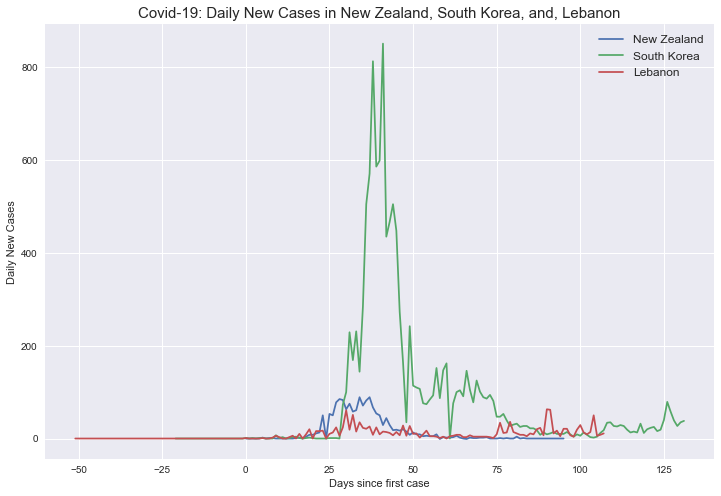

In [19]:
plot_stats(countries, 'Daily New Cases', 'New Zealand', 'South Korea', 'Lebanon', save_output=True, y_log_scale=False)

Brazil, Russia, and the US have all received attention due to their slow response to the spread of the virus. India is included here for comparison in next graph.

*https://www.reuters.com/article/us-health-coronavirus-haseltine-newsmake/top-hiv-scientist-says-he-wouldnt-count-on-a-vaccine-for-coronavirus-soon-idUSKBN22W34T

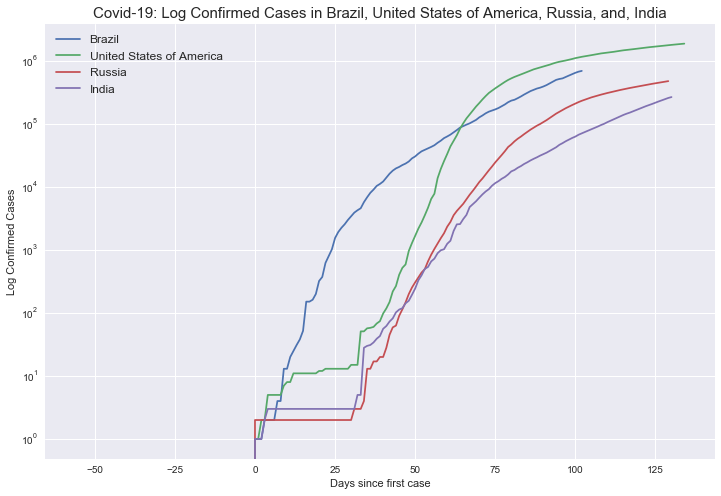

In [20]:
plot_stats(countries, 'Confirmed Cases', 'Brazil', 'United States of America', 'Russia', 'India')

When controlling for population, there is not much change in the graph except India, which experiences a significant downwards shift relative to the other three countries' trends.

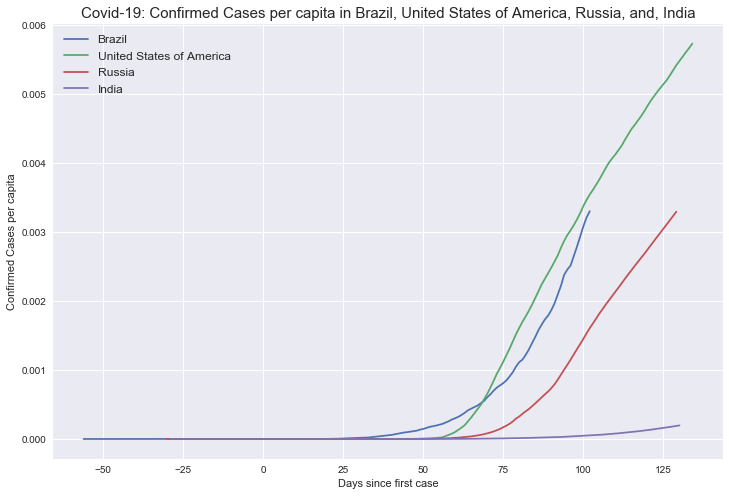

In [21]:
plot_stats(countries, 'Confirmed Cases', 'Brazil', 'United States of America', 'Russia', 'India', save_output=False,per_capita=True, y_log_scale=False)

The daily number of new cases gives a good picture of virus trends of each country.

Graph idea from Oxford Covid Gov Response Tracker Website: Government response against confirmed cases.
Gov Response index tends to go up as number of cases increase. It is the latter thaat causes the former, and not the other way around. 

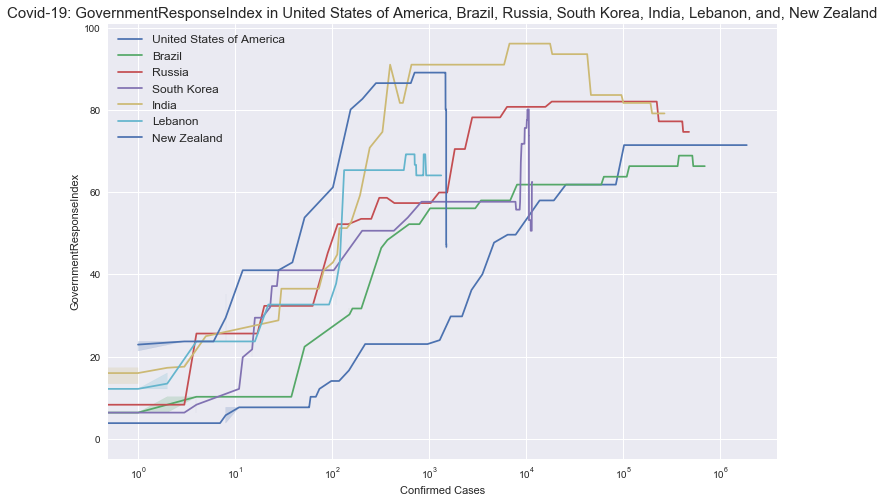

In [22]:
plot_stats(countries, 'GovernmentResponseIndex',  
           'United States of America', 'Brazil', 'Russia', 'South Korea', 'India', 'Lebanon', 'New Zealand',
           x_var='Confirmed Cases', y_log_scale=False, x_log_scale=True, annotate=False)

Exploring the relationship modeled in the graph above. There seems to be a strong influence of cases on Government Response Index.
South Korea seems to have the weakest correlation between the two (albeit it is very strong); we interpret this to mean that the Korean government is more willing to take action independent of the number of cases.

In [23]:
from numpy import inf
from scipy.stats.stats import pearsonr
np.seterr(divide = 'ignore') 

def df_correlates(df, var1, var2, country ,log_x=False, log_y=False):
    x = np.array(df[df['Country'] == country][var1])
    y = np.array(df[df['Country'] == country][var2])
    if log_x:
        x = np.log(x)
        x[x==-inf] = 0 
    if log_y:
        y = np.log(y)
        y[y == -inf] = 0
        print('y', country)
    y = y[~np.isnan(y)]
    x= x[:len(y)]
    corr, p = pearsonr(x,y)
    statement = '{}: {} and {} '.format(country, var1, var2)
    print(statement, '\ncorrelation:', corr, '\nP-value:', p, '\n')

df_correlates(countries, 'Confirmed Cases',  'GovernmentResponseIndex', country='United States of America', log_x=True)
df_correlates(countries, 'Confirmed Cases',  'GovernmentResponseIndex', country='Brazil', log_x=True)
df_correlates(countries, 'Confirmed Cases',  'GovernmentResponseIndex', country='Russia', log_x=True)
df_correlates(countries, 'Confirmed Cases',  'GovernmentResponseIndex', country='South Korea', log_x=True)
df_correlates(countries, 'Confirmed Cases',  'GovernmentResponseIndex', country='New Zealand', log_x=True)
df_correlates(countries, 'Confirmed Cases',  'GovernmentResponseIndex', country='China', log_x=True)
df_correlates(countries, 'Confirmed Cases',  'GovernmentResponseIndex', country='India', log_x=True)


United States of America: Confirmed Cases and GovernmentResponseIndex  
correlation: 0.9879590306226207 
P-value: 1.0022392281113962e-126 

Brazil: Confirmed Cases and GovernmentResponseIndex  
correlation: 0.9818736171307898 
P-value: 2.564656147933185e-115 

Russia: Confirmed Cases and GovernmentResponseIndex  
correlation: 0.9677450000095827 
P-value: 1.654561357275542e-96 

South Korea: Confirmed Cases and GovernmentResponseIndex  
correlation: 0.9177132994572206 
P-value: 2.0232595779314633e-62 

New Zealand: Confirmed Cases and GovernmentResponseIndex  
correlation: 0.7461405934576746 
P-value: 2.7006894842114104e-18 

China: Confirmed Cases and GovernmentResponseIndex  
correlation: 0.9504053818222422 
P-value: 5.648252565257293e-78 

India: Confirmed Cases and GovernmentResponseIndex  
correlation: 0.9314414206067456 
P-value: 2.9233458498362408e-71 



The global trend is a strong correlation between the two. Interestingly, it is not as strong as the correlation coefficients of the countries above. 

In [24]:
log_cases = np.log(countries['Confirmed Cases'])
log_cases[log_cases == -inf] = 0 
countries['GovernmentResponseIndex'].corr(log_cases)

0.8365292993033765

From the health measures, Current Health Expenditure Per Capita seems to have the strongest correlation with deaths and no. cases, .487 and .454, respectively. 
This could be possible explained by the fact that countries that spend more on public health tend to carry out more tests and report more deaths.  

In [25]:
countries.groupby('Country')['Days Elapsed Since First Case'].max().reset_index(name='day').sort_values(by='day')

,Country,day
82,Lesotho,26.0
47,Eritrea,37.0
136,Tajikistan,38.0
24,Burundi,58.0
152,Yemen,59.0
...,...,...
147,United States of America,134.0
74,Japan,134.0
138,Thailand,135.0
99,Nepal,135.0


#### Exporting the 'countries' data frame to the data folder via pickle

In [26]:
countries.to_pickle('.\\..\\data\\covid_df_protocol_3.pkl', protocol = 3)
countries.to_pickle('.\\..\\data\\covid_df.pkl')

countries.drop(columns=list(wb_data.columns)[1:], inplace=True)
countries2 = pd.get_dummies(countries, columns=['Country'])

countries2.to_pickle('.\\..\\data\\one_hot_df.pkl')
countries2.to_pickle('.\\..\\data\\one_hot_df_protocol_3.pkl', protocol = 3)